In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from datetime import datetime, timedelta

import torch, random, time, os, re, warnings
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.tensorboard import SummaryWriter
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from lime.lime_text import LimeTextExplainer

In [2]:
#only hangle, english, number
from krwordrank.hangle import normalize

#soyspacing
from soyspacing.countbase import CountSpace
from soyspacing.countbase import RuleDict

#soy_tokenizer
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer, MaxScoreTokenizer, MaxLRScoreTokenizer
from soynlp.noun import LRNounExtractor_v2
from soynlp.hangle import compose, decompose, character_is_korean
from konlpy.tag import Okt

#jamo
import re

import os
from datetime import datetime
import pickle
import copy
import numpy as np
import sentencepiece as spm
from itertools import islice
from gensim.models.phrases import Phrases

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
%matplotlib inline

plt.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
use_cuda = False

In [4]:
warnings.filterwarnings(action='ignore')

In [5]:
def span_str(color, input_str):
    string = '<span style="margin-left:3px;background-color:rgba({})">{}</span>'.format(color, input_str)
    return string

In [6]:
def add_rating(data=None,content=None,ratings=None):
    def transform_rating(rating):
        transformed_word = None
        if str(rating).startswith('1'):
            transformed_word = 'దూరంలో'
        elif str(rating).startswith('2'):
            transformed_word = 'ուսումնասիրությունների'
        elif str(rating).startswith('3'):
            transformed_word = 'राज्ययागु'
        elif str(rating).startswith('4'):
            transformed_word = 'திருக்கோவில்கள்'
        elif str(rating).startswith('5'):
            transformed_word = 'நாட்டின்'
        # if rating in [1, '1', 1.0, '1.0', 1.5, '1.5']:
        #     transformed_word = 'దూరంలో'
        # elif rating in [2, '2', 2.0, '2.0', 2.5, '2.5']:
        #     transformed_word = 'ուսումնասիրությունների'
        # elif rating in [3, '3', 3.0, '3.0', 3.5, '3.5']:
        #     transformed_word = 'राज्ययागु'
        # elif rating in [4, '4', 4.0, '4.0', 4.5, '4.5']:
        #     transformed_word = 'திருக்கோவில்கள்'
        # elif rating in [5, '5', 5.0, '5.0']:
        #     transformed_word = 'நாட்டின்'
        return transformed_word

    if data is not None:
        data['리뷰'] = data.apply(lambda x: transform_rating(x['rating']) + ' ' + x['리뷰'], axis=1)
        return data

    elif content is not None and ratings is not None:
        # sentence and rating are lists
        content = [transform_rating(rating) + ' ' + sentence for sentence, rating in zip(content, ratings)]
        return content

In [7]:
def predict(sentences):
    result = list()
    for sentence in sentences:
        sentence = copy.deepcopy(sentence)
        b_input_ids, b_input_mask = tokenizing(sentences=[sentence])
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        result.append(softmax(logits[0]))
    return np.array(result)

In [8]:
def write_html_lime(contents, reviews, targets, preds, vis_path, acc, n_reviews=None, label=None):
    def get_ordered_list(alphas, review):
        result = list()
        for token in review.split():
            prob = alphas.get(token, 0)
            if prob > 0.15 and prob < 0.8:
                result.append((token, prob))
        return result
    if not n_reviews:
        n_reviews = len(reviews)
    alpha_list = list()
    with open(vis_path, 'w', encoding='utf-8') as file:
        print('<html style="margin:0;padding:0;"><body style="margin:0;padding:0;">\n', file=file)
        print('<div style="margin:25px;">\n', file=file)
        print('<h1>Total Accuracy: {:.4f}</h1>'.format(acc), file=file)
        i = 0
        for review, content, target, preds in tqdm(zip(contents, reviews, targets, preds), total=n_reviews):
            review = review[0]
            print("review ", review)
            if i == n_reviews:
                break
            i += 1
            explanation = explainer.explain_instance(review, predict, num_samples=100, num_features=10, labels=[label,])
            if target == 1:
                continue
            if target != preds:
                continue
            alphas = dict(explanation.as_list(label=label))
            alpha_list.append(get_ordered_list(alphas, review))
            print('<p style="margin:10px;">\n', file=file)
            if target == preds:
                color = '154,226,143, 0.7'
                input_str = '[target: {}| pred: {}]'
                string = span_str(color, input_str)
                print(string.format(target, preds), file=file)
            else:
                color = '203,127,230, 0.7'
                input_str = '[target: {}| pred: {}]'
                string = span_str(color, input_str)
                print(string.format(target, preds), file=file)
            for word in content.split():
                value = abs(alphas.get(word, 0))
                if target == 0:
                    color = '255,50,50, {}'
                else:
                    color = '45, 255, 255, {}'
                input_str = '{}'
                string = span_str(color, input_str)
                print(('\t' + string + '\n').format(value, word), file=file)
            print('</p>\n', file=file)
        print('</div>\n', file=file)
        print('</body></html>', file=file)
        return alpha_list

In [9]:
include_english = False
include_number = False

'''
Process Hangul Jamo Sentence.
Inspired By:
https://lovit.github.io/nlp/representation/2018/10/22/fasttext_subword
'''
def clean_review(text):
    presuffix_list = [
    '가격만족도 성능 사용편의성 등',
    '가격만족도성능사용편의성 등',
    '재구매횟수 또는 기간',
    '그 외 도움이 될 만한 사용후기',
    '상태 배송',
    '옥션 안드로이드 앱으로 작성',
    'G마켓 안드로이드 앱에서 작성',
    '상태배송'
    ]
    text = str(text)
    for presuffix in presuffix_list:
        text = text.replace(presuffix, '')
    text = ' '.join(re.compile('[가-힣]+').findall(text))
    if len(text):
        return text.strip()
    else:
        return np.nan

doublespace_pattern = re.compile('\s+')
def jamo_to_word(jamo):
    jamo_list, idx = [], 0
    while idx < len(jamo):
        if not character_is_korean(jamo[idx]):
            jamo_list.append(jamo[idx])
            idx += 1
        else:
            jamo_list.append(jamo[idx:idx + 3])
            idx += 3
    word = ""
    for jamo_char in jamo_list:
        if len(jamo_char) == 1:
            word += jamo_char
        # elif jamo_char[1] == "-" and jamo_char[2] == "-":   ###자음 하나만 나오는 경우
        #     word += jamo_char[0]
        # elif jamo_char[0] == "-" and jamo_char[2] == "-":   ###모음 하나만 나오는 경우
        #     word += jamo_char[1]
        elif len(jamo_char) == 2:
            word += compose(jamo_char[0], jamo_char[1], " ")
        elif jamo_char[2] == "-":
            word += compose(jamo_char[0], jamo_char[1], " ")
        else:
            word += compose(jamo_char[0], jamo_char[1], jamo_char[2])
    return word

def jamo_sentence(sent):

    def transform(char):
        if char == ' ':
            return char
        cjj = decompose(char)
        if len(cjj) == 1:
            return cjj
        cjj_ = ''.join(c if c != ' ' else '-' for c in cjj)
        return cjj_

    sent_ = []
    for char in sent:
        if character_is_korean(char):
            sent_.append(transform(char))
        else:
            sent_.append(char)
    sent_ = doublespace_pattern.sub(' ', ''.join(sent_))
    return sent_

class Tokenizer():
    def __init__(self, space_correction, model_path):
        self.space_correction = space_correction
        self.model_path = model_path

        self.tokenizer_dir = os.path.join(self.model_path, 'tokenizer','soynlp')
        if not os.path.exists(self.tokenizer_dir): os.makedirs(self.tokenizer_dir)

    def apply_soyspacing(self):
        # spacing_correction
            model = CountSpace()
            model.load_model(os.path.join(self.model_path, 'model_soyspacing'), json_format=False)

            rule_file = os.path.join(self.model_path, 'spacing_rules')
            mc = 10  # min_count
            ft = 0.3  # force_abs_threshold
            nt = -0.3  # nonspace_threshold
            st = 0.3  # space_threshold

            rule_dict = None
            # #specific rules for spacing
            # if not rule_file:
            #     rule_dict = None
            # else:
            #     rule_dict = RuleDict(rule_file)

            # correct
            print('spacing is correcting.....')
            for file in tqdm(self.texts.keys()):
                text_tmp = []
                for text in self.texts[file]:
                    text_corrected, tags = model.correct(doc=text, verbose=False, force_abs_threshold=ft,
                                                         nonspace_threshold=nt, space_threshold=st, min_count=mc,
                                                         rules=rule_dict)
                    text_tmp.append(text_corrected)
                self.texts[file] = text_tmp

    def train(self, texts, subword, tokenizer_name=str(datetime.now())):
        self.texts = texts

        texts_tmp = copy.deepcopy(self.texts)
        self.texts = {}
        for key, values in texts_tmp.items():
            if isinstance(values, str) or isinstance(values, float):
                self.texts[key] = normalize(str(values).replace('\n', '  '), english=include_english, number=include_number)
            elif isinstance(values, list):
                self.texts[key] = [normalize(value.replace('\n', '  '), english=include_english, number=include_number) for value in values]

        if self.space_correction == True: self.apply_soyspacing()

        # subword
        scores = {}
        if subword == 0:
            print('no subword treatment')

        elif subword ==11 or subword==12:
            print('mecab does not need traning')

        # soynlp:: word score를 저장
        elif subword == 2 or subword == 3 or subword == 23:
            text_all = [text for texts in self.texts.values() for text in texts]

            if subword == 2:
                word_extractor = WordExtractor(min_frequency=2, min_cohesion_forward=0.05,
                                               min_right_branching_entropy=0.01)
                word_extractor.train(text_all)
                word_score = word_extractor.extract()
                print('number of scored words = %d' % len(word_score))

                # with open('soynlp.vocab','w') as f:
                #    for word, score in sorted(word_score.items(), key=lambda x: x[1], reverse=True):
                #        #print(str(word) + '\t' + str(score.cohesion_forward) + '   ' + str(score.right_branching_entropy))
                #        f.write(str(word)+'\t'+str(float(score.cohesion_forward))+'   '+str(float(score.right_branching_entropy))+'\n')

                scores = {word: score.cohesion_forward for word, score in word_score.items()}
            elif subword == 3:
                noun_extractor = LRNounExtractor_v2(verbose=False)
                nouns = noun_extractor.train_extract(text_all)
                scores = {noun: score.score for noun, score in nouns.items()}
            elif subword == 23:
                word_extractor = WordExtractor(min_frequency=2, min_cohesion_forward=0.05,
                                               min_right_branching_entropy=0.01)
                word_extractor.train(text_all)
                word_score = word_extractor.extract()
                print('number of scored words = %d' % len(word_score))

                cohension_branching_scores = {word: score.cohesion_forward * score.right_branching_entropy for
                                              word, score
                                              in word_score.items()}
                # cohension_scores = {word:score.cohesion_forward for word, score in word_score.items()}

                noun_extractor = LRNounExtractor_v2(verbose=False)
                nouns = noun_extractor.train_extract(text_all)
                noun_scores = {noun: score.score for noun, score in nouns.items()}

                scores = {noun: score + cohension_branching_scores.get(noun, 0) for noun, score in noun_scores.items()}
                for token, cohesion in cohension_branching_scores.items():
                    if token not in scores: scores.update({token: cohesion})
                
            #tokenizer_name = str(datetime.now().strftime('%Y%m%d')[2:]) + '_tokenizer' + tokenizer_name #str(self.texts.keys())[10:-1].replace('/','_') #str(subword)
            with open(os.path.join(self.tokenizer_dir, tokenizer_name), 'wb') as f:
                pickle.dump(scores, f, protocol=pickle.HIGHEST_PROTOCOL)

        elif subword == 4:
            self.tokenizer_dir = os.path.join(self.model_path, 'tokenizer','sentencepiece')
            model_path = os.path.join(self.tokenizer_dir, tokenizer_name)
            texts = [clean_review(text) for texts in self.texts.values() for text in texts]
            print('SUBWORD4')
            temp_file = 'temp.txt'
            with open (temp_file, 'w') as f:
                for text in texts:
                    if len(texts):
                        f.write(str(text))
                        f.write('\n')
            if not os.path.exists(model_path):
                os.mkdir(model_path)
            spm.SentencePieceTrainer.Train('--input={} --model_prefix={} --vocab_size=5000 --bos_id=-1 --eos_id=-1 --unk_id=1 --pad_id=0 --model_type=bpe'.format(temp_file, os.path.join(model_path, 'spm')))
            print('Done')
            os.remove(temp_file)

    def run(self, texts, subword, jamo, tokenizer_name=None):
        self.texts = texts

        # 한글 영어 숫자만 남기고 다 지움.
        texts_tmp = copy.deepcopy(self.texts)
        self.texts = {}
        for key, values in texts_tmp.items():
            if isinstance(values, str) or isinstance(values, float):
                self.texts[key] = normalize(str(values).replace('\n', '  '), english=include_english, number=include_number)
            elif isinstance(values, list):
                self.texts[key] = [normalize(value.replace('\n', '  '), english=include_english, number=include_number) for value in values]

        if self.space_correction == True: self.apply_soyspacing()

        if subword == 0:
            pass

        elif subword ==11 or subword==12:
            from konlpy.tag import Mecab
            ##내용파악에는 명사추출이 좋으나, 의도파악에는 형태소 분석이 좋다.
            if subword ==11 :
                mecab = Mecab().morphs
                for file in self.texts.keys():
                    text_tmp = []
                    for text in self.texts[file]:
                        #print('before',text)
                        text_subword = ''
                        for token in mecab(text):
                            text_subword += token + ' '
                        #print('after',text_subword)
                        text_tmp.append(text_subword)
                    self.texts[file] = text_tmp
            elif subword == 12:
                mecab = Mecab().nouns
                for file in self.texts.keys():
                    text_tmp = []
                    for text in self.texts[file]:
                        #print('before',text)
                        text_subword = ''
                        for token in mecab(text):
                            if len(token) == 1: continue
                            text_subword += token + ' '
                        #print('after',text_subword)
                        text_tmp.append(text_subword)
                    self.texts[file] = text_tmp

        elif subword in os.listdir(self.tokenizer_dir):
            with open(os.path.join(self.tokenizer_dir,subword),'rb') as f:
                scores = pickle.load(f)

            #transform
            ltokenizer = LTokenizer(scores = scores)
            for file in self.texts.keys():
                text_tmp = []
                for text in self.texts[file]:
                    #print('before',text)
                    text_token = ''
                    for token in ltokenizer.tokenize(text):
                        if token not in scores: continue
                        if scores[token] < 0.1: continue  #print(subword, scores[subword])
                        text_token += token+' '
                    #print('after',text_token)
                    text_tmp.append(text_token)
                self.texts[file] = text_tmp

        elif subword==4:
            sp = spm.SentencePieceProcessor()
            sp_path = os.path.join(self.model_path, 'tokenizer', 'sentencepiece', tokenizer_name, 'spm.model')
            sp.load(sp_path)
            for i, sentence in  tqdm(enumerate(texts['content'])):
                texts['content'][i] = sp.EncodeAsPieces(sentence)

        else:
            print('subword option ',subword,' is not recognized')

        if jamo == True:
            texts_tmp = copy.deepcopy(self.texts)
            self.texts = {}
            for key, values in texts_tmp.items():
                if isinstance(values,str):
                    self.texts[key] = jamo_sentence(values)
                elif isinstance(values,list):
                    self.texts[key] = [jamo_sentence(value) for value in values]

        return self.texts


In [10]:
def del_gmarket_auction(text):
    presuffix_list = [
            '가격만족도 성능 사용편의성 등',
            '가격만족도성능사용편의성 등',
            '재구매횟수 또는 기간',
            '그 외 도움이 될 만한 사용후기',
            '상태 배송',
            '옥션 안드로이드 앱으로 작성',
            'G마켓 안드로이드 앱에서 작성',
            '상태배송'
        ]
    for presuffix in presuffix_list:
            text = text.replace(presuffix, '')
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!;』\\‘|\(\)\[\]\<\>`\'…》]', '', text).replace('\n', ' ').replace('\t', ' ').strip()
    if len(text):
        return text
    else:
        return np.nan

In [11]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))  # 반올림
    return str(timedelta(seconds=elapsed_rounded))  # hh:mm:ss으로 형태 변경

In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
def tokenizing(sentences):
    for i in range(len(sentences)):
        sentences[i] = "[CLS] " + str(sentences[i]) + " [SEP]"

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 self.MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    inputs = torch.tensor(input_ids).to(device)
    masks = torch.tensor(attention_masks).to(device)

    return inputs, masks

In [14]:
def inference(sentences, get_logit=False):
    b_input_ids, b_input_mask = tokenizing(sentences=sentences)
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    if get_logit:
        return logits
    else:
        return [np.argmax(logit) for logit in logits]

In [15]:
def get_tokens(sentence):
    tokens = [token for token, pos in okt.pos(sentence) if pos in tag_list]
    return ' '.join(tokens)

In [16]:
MAX_LEN=128

In [17]:
dataset_path = '../../hit_prediction/dataset/bert_model_dataset/'

In [18]:
model_path = '../../hit_prediction/model'

In [19]:
tag_list = ['Noun', 'Verb', 'Adjective', 'Adverb']

In [20]:
okt = Okt()

-----------

In [21]:
factor_name = '맛'

In [22]:
filename = list(filter(lambda x : factor_name in x, os.listdir(dataset_path)))[0]

In [23]:
# dataset = pd.read_excel(os.path.join(dataset_path, filename))
dataset = pd.read_pickle('../../hit_prediction/log/classification/200820_1438_종근당 프로메가 고순도 알티지오메가3.pkl')
dataset['리뷰'] = dataset['리뷰'].map(del_gmarket_auction)

In [24]:
dataset.head()

,리뷰,rating,맛,효과,영양성분
0,두드러기가 셍겼어요,1,1,2,2
1,생선 비린네가 나지않아 먹기좋아요,4,1,3,3
2,알이 작아서 목 넘김이 좋아요 비린내는 없는 건 아니구요 있기는 있어요 근데 저는 ...,4,1,2,2
3,알이 작아서 다른거 보단 편하긴 한데 그래도 저에겐 맛이나 넘김이 조금 불편하긴해요,4,1,2,2
4,기존 오메가 는 냄새때문에 먹기 좀 불편했는데 이 제품은 냄새가 거의 없어서 먹기 ...,4,1,2,3


In [25]:
# dataset = dataset[dataset['구분'] != 4]
# dataset = dataset[dataset['구분'] != 2]
# dataset['구분'] = dataset['구분'].apply(lambda x: 2 if x==0 else x)
# dataset['구분'] = dataset['구분']-1

In [26]:
dataset.dropna(inplace=True)

In [27]:
dataset.shape

(6015, 5)

In [28]:
dataset['리뷰'] = pd.Series(Tokenizer(space_correction=False, model_path=model_path).run(dataset['리뷰'], subword=0, jamo=False))
# dataset['리뷰'] = dataset['리뷰'].map(get_tokens)

In [29]:
# dataset['맛'] = dataset['맛'].map({0:1, 1:0, 2:1, 3:2})
# dataset['효과'] = dataset['효과'].map({0:1, 1:0, 2:1, 3:2})
# dataset['성분'] = dataset['성분'].map({0:1, 1:0, 2:1, 3:2})
dataset['구분'] = dataset[factor_name].map({0:1, 1:0, 2:1, 3:2})

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [31]:
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [32]:
device

device(type='cpu')

In [33]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [34]:
model.load_state_dict(torch.load('../../hit_prediction/model/classification_model/bert_model/{}/pytorch_model.bin'.format(factor_name), map_location=device))

<All keys matched successfully>

In [35]:
if use_cuda:
    model.cuda()
else:
    model.cpu()

In [36]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [42]:
dataset = add_rating(dataset)

In [43]:
reviews = dataset['리뷰'].values
ratings = dataset['rating'].values
scores = dataset['구분'].values

In [44]:
_, validation_reviews, _, validation_scores = train_test_split(reviews, scores, random_state=2018, test_size=0.15)

In [45]:
# contents = [[review] for review in validation_reviews]
contents = [[review] for review in reviews]

In [46]:
yhat = list()
for review in tqdm(contents):
    yhat.extend(inference(review))

KeyboardInterrupt: 

In [47]:
print(classification_report(scores, yhat))
acc = accuracy_score(scores, yhat)

ValueError: Found input variables with inconsistent numbers of samples: [6015, 44]

In [54]:
print(classification_report(scores, yhat))
acc = accuracy_score(scores, yhat)

              precision    recall  f1-score   support

           0       0.46      0.65      0.54        69
           1       0.97      0.98      0.98      5575
           2       0.65      0.55      0.60       371

    accuracy                           0.95      6015
   macro avg       0.69      0.73      0.70      6015
weighted avg       0.95      0.95      0.95      6015



In [43]:
vis_path = './{}_lime_bert.html'.format(factor_name)

In [48]:
explainer = LimeTextExplainer()

In [49]:
label = 2

In [50]:
true_index = np.asarray(scores) == label

In [51]:
origin_reviews = dataset['리뷰'].values

In [52]:
alpha_list = write_html_lime(np.asarray(contents)[true_index], reviews[true_index], np.asarray(scores)[true_index], np.asarray(yhat)[true_index], vis_path, acc, label=label)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 44 but corresponding boolean dimension is 6015

In [53]:
import pickle

In [54]:
with open('alpha_list', 'rb') as f:
    alpha_list = pickle.load(f)

In [55]:
origin_reviews[true_index]

array(['திருக்கோவில்கள் 알이 작아 먹기 편하고 비린냄새도 안나서 좋아요',
       'நாட்டின் 좋아요 좋아요 좋아요 좋아요',
       'நாட்டின் 기다리던 제품이 왔어요 부모 드시고 싶다고 하셔서 주문했어요 꾸준히 먹어보고 효과있는지 궁금하네요 좋아요',
       'நாட்டின் 비릿한향도 없고 먹을만하네요',
       'நாட்டின் 아주만족합니다 오메가 인데도 목넘김 부드럽고 비린맛없고 먹기편하고 한잘먹어서 아직 드라마틱한 변화는 못느끼지만 꾸준히 복용하려합니다',
       'நாட்டின் 오메가 를 비린내가 올라와 복용을 중지 했었는데 이 제품은 괜찮네요',
       'நாட்டின் 일반 오메가 는 비린내가 올라온다고 해서 주문해봤습니다',
       'நாட்டின் 좋아요 잘 먹고있어요 여기꺼 젤 좋데서 소개받고 먹는중입니다',
       'நாட்டின் 목넘긴도 좋구 아주 좋아요', 'நாட்டின் 재구매했습니다 먹기도 편하고 좋아요',
       'திருக்கோவில்கள் 비릿한 맛도 없고 정제가 작아서인지 목넘김도 좋아요',
       'நாட்டின் 알도 작고 비린맛이 전 느껴지지 않아서 좋았어요', 'நாட்டின் 맛있어요',
       'நாட்டின் 꼭 필요한 제품 오메가 알약크기가 넘 만족스러운 크기 다른제품은 목넘기기 넘 불편해서 먹다 중단했는데 함량도 좋아 굿 하루 회 정',
       'திருக்கோவில்கள் 매일 아침에 잘 먹고 있어요 냄새가 안나서 좋아요',
       'நாட்டின் 엄마가 콜레스테롤 수치가 높아서 사드린건데 좋아하시네요 꼭 효과있길 바래봅니다',
       'நாட்டின் 오메가 특유의 향때문에 먹눈게 힘들었는데 이제품은 그런 향 전혀 안나고 알 크기도 작아서 목넘김도 좋아요',
       'நாட்டின் 아주 좋네요 고맙습니다', 'நாட்டின் 비린내가 올라오지않아요 좋습니다',
       'திருக

In [56]:
word_score_dict = dict()
for review in alpha_list:
    if len(review):
        for token, score in review:
            word_score_dict[token] = word_score_dict.get(token, list()) + [score,]

In [57]:
for k, v in word_score_dict.items():
    mean_value = np.mean(v)
    if mean_value < 0.2:
        word_score_dict[k] = 0
    else:
        word_score_dict[k] = mean_value

### WordCloud

In [58]:
from wordcloud import WordCloud

In [59]:
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [60]:
bad_words = word_score_dict

In [61]:
def color_func(word, *args, **kwargs):
    if word in bad_words.keys():
        color = 'firebrick' # red
    elif word in good_words.keys():
        color = 'mediumblue' # blue
    else:
        color = 'black' # black
    return color

In [65]:
wordcloud = WordCloud(
    font_path = font_path,
    width = 800,
    height = 800,
    max_words=30,
    background_color="white",
    prefer_horizontal=1
#     color_func=color_func
)
wordcloud = wordcloud.generate_from_frequencies(word_score_dict)

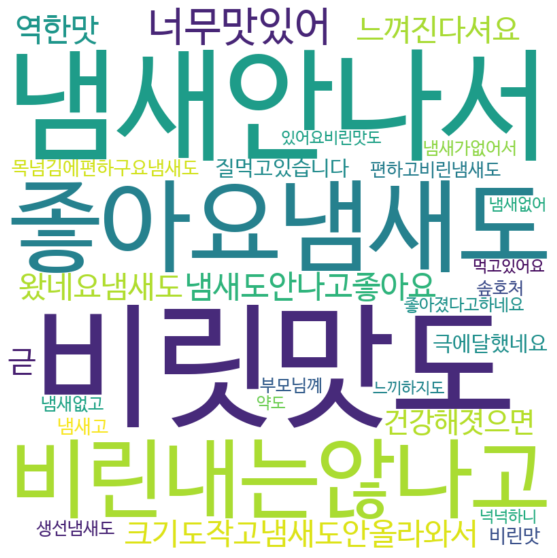

In [66]:
array = wordcloud.to_array()
fig = plt.figure(figsize=(10, 10))
plt.imshow(array, interpolation="bilinear")
plt.axis("off")
plt.show()

### KeywordMap

In [83]:
from networkx.drawing.nx_pydot import graphviz_layout
import networkx as nx

In [84]:
font_path = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
fontprop = fm.FontProperties(fname=font_path, size=5)

In [85]:
okt = Okt()

In [86]:
token_coocur = [[k for k, _ in review] for review in alpha_list]

In [87]:
corpus = []
for review in tqdm(token_coocur):
    corpus.append(get_tokens(' '.join(review)).split())

In [88]:
bigram = Phrases(corpus, min_count=1, threshold=1)
trigram = Phrases(bigram[corpus], min_count=1)

In [89]:
ngram_corpus = [[token for token in trigram[review] if len(token)>1] for review in corpus]

In [90]:
count_dict = Counter()
for ngram_review in ngram_corpus:
    count_dict.update(Counter(ngram_review))

In [241]:
word_pair_freq = dict()
for review in tqdm(ngram_corpus):
    for pair, freq in Counter(zip(review, islice(review, 1, None))).items():
        word_pair_freq[pair] = word_pair_freq.get(pair, 1) + freq

In [92]:
wordpair_df = pd.DataFrame(word_pair_freq.items(), columns=['pair', 'count'])

In [93]:
wordpair_df.sort_values(by='count', ascending=False, inplace=True)

In [94]:
n_pair = min(50, sum(wordpair_df['count'] > 1))
data = wordpair_df.iloc[:n_pair]

# ************************

In [258]:
corpus = [token for token in corpus if len(token)>1]

In [271]:
not_ngram_word_pair_freq = dict()
for review in tqdm(corpus):
    for pair, freq in Counter(zip(review, islice(review, 1, None))).items():
        not_ngram_word_pair_freq[pair] = not_ngram_word_pair_freq.get(pair, 1) + freq

In [272]:
not_ngram_word_pair_freq

{('먹기', '비린'): 2,
 ('비린', '냄새'): 6,
 ('냄새', '좋아요'): 16,
 ('인데도', '비린'): 2,
 ('비린', '맛없고'): 2,
 ('목', '넘긴도'): 2,
 ('넘긴도', '좋아요'): 2,
 ('맛', '좋아요'): 4,
 ('느껴지지', '좋았어요'): 2,
 ('사', '드린건데'): 2,
 ('드린건데', '바'): 2,
 ('바', '봅니다'): 2,
 ('향', '때문'): 2,
 ('때문', '향'): 2,
 ('향', '작아서'): 2,
 ('작아서', '좋아요'): 2,
 ('좋네요', '고맙습니다'): 2,
 ('크지', '않아'): 2,
 ('않아', '편하고'): 2,
 ('편하고', '비린'): 3,
 ('비린', '맛'): 20,
 ('포장', '깔끔하고'): 2,
 ('깔끔하고', '효'): 2,
 ('효', '과기대'): 3,
 ('과기대', '해봅니다'): 3,
 ('목', '넘김'): 9,
 ('넘김', '이편'): 2,
 ('이편', '냄새'): 2,
 ('냄새', '안더'): 2,
 ('안더', '조아요'): 2,
 ('좋아요', '냄새'): 5,
 ('냄새', '없고'): 4,
 ('없고', '좋아요'): 2,
 ('편하고', '비린내'): 2,
 ('비린내', '좋습니다'): 3,
 ('쓰고', '달아요'): 2,
 ('비린내는', '않나고'): 2,
 ('좋아요', '귿'): 2,
 ('귿', '좋아요'): 2,
 ('먹고있는데', '비린내'): 2,
 ('비린내', '없이'): 2,
 ('없이', '딱좋습니다'): 2,
 ('맡은', '적'): 2,
 ('적', '느껴지는'): 2,
 ('넘김', '좋고'): 3,
 ('좋고', '비린내가'): 3,
 ('비린내가', '나지'): 2,
 ('나지', '않아서'): 2,
 ('않아서', '좋네요'): 2,
 ('오메가', '비린내'): 2,
 ('적당하여', '역겨운'): 2,
 ('역겨운', '냄새'): 2,
 ('냄새', 

In [273]:
wordpair_df = pd.DataFrame(not_ngram_word_pair_freq.items(), columns=['pair', 'count'])

In [274]:
wordpair_df.sort_values(by='count', ascending=False, inplace=True)

In [275]:
n_pair = min(50, sum(wordpair_df['count'] > 1))
data = wordpair_df.iloc[:n_pair]

In [276]:
data = data.reset_index(drop=True)

In [277]:
data.loc[1:]

,pair,count
1,"(비린, 맛)",20
2,"(냄새, 좋아요)",16
3,"(냄새, 안나)",11
4,"(목, 넘김)",9
5,"(비린, 냄새)",6
6,"(생선, 냄새)",6
7,"(냄새, 좋습니다)",6
8,"(좋아요, 냄새)",5
9,"(맛, 좋네요)",4
10,"(냄새, 없고)",4


In [278]:
from gensim.models import FastText

In [279]:
prep_reviews = [okt.morphs(review)[1:] for review in tqdm(origin_reviews)]

In [215]:
fasttext = FastText(sg=1, size=384, workers=8, word_ngrams=3, min_count=1)
fasttext.build_vocab(sentences=prep_reviews)
fasttext.train(sentences=prep_reviews, total_examples=fasttext.corpus_count, epochs=20)

In [290]:
fasttext.wv.similar_by_word("냄새", topn=30)

[('비린내안', 0.7972832322120667),
 ('비린거', 0.7878749966621399),
 ('비린내안나서', 0.7773857116699219),
 ('비린내는', 0.7726625204086304),
 ('비린네', 0.7709571123123169),
 ('비린내가', 0.7666102647781372),
 ('비린것도', 0.7660048007965088),
 ('비린내', 0.7628566026687622),
 ('비린', 0.7609537243843079),
 ('비린내에', 0.7587089538574219),
 ('트름해', 0.7475259304046631),
 ('비린내안나고', 0.746959388256073),
 ('전혀', 0.7437519431114197),
 ('비릿내', 0.7425493001937866),
 ('트름', 0.7425413727760315),
 ('올라오는', 0.7408324480056763),
 ('특유', 0.734177827835083),
 ('올라오는것도', 0.7336069941520691),
 ('비린내도', 0.7328088283538818),
 ('어취', 0.7293080687522888),
 ('올라오고', 0.7289197444915771),
 ('해도', 0.7227672934532166),
 ('없구', 0.7204760909080505),
 ('넘어가요', 0.720268964767456),
 ('는것도', 0.7201745510101318),
 ('넘어오지', 0.7159915566444397),
 ('향', 0.7146251201629639),
 ('올라오는거', 0.7134690284729004),
 ('생선', 0.712098240852356),
 ('올라오던데', 0.7112855911254883)]

In [228]:
fasttext.wv.similarity('비린내','비릿내')

0.77793944

In [280]:
data

,pair,count
0,"(좋아요, 좋아요)",26
1,"(비린, 맛)",20
2,"(냄새, 좋아요)",16
3,"(냄새, 안나)",11
4,"(목, 넘김)",9
5,"(비린, 냄새)",6
6,"(생선, 냄새)",6
7,"(냄새, 좋습니다)",6
8,"(좋아요, 냄새)",5
9,"(맛, 좋네요)",4


In [109]:
tag_list = ['Noun', 'Verb', 'Adjective', 'Adverb']

In [236]:
data

,pair,count
27,"(좋아요, 좋아요)",27
6,"(냄새, 좋아요)",14
39,"(냄새, 좋습니다)",4
21,"(냄새, 없고)",4
15,"(과기대, 해봅니다)",3
98,"(였음, 좋겠어요)",3
110,"(좋아요, 비린_맛)",3
97,"(효과, 였음)",3
111,"(비린_맛, 좋네요)",3
20,"(좋아요, 냄새)",3


In [233]:
ngram_corpus

[['먹기', '비린_냄새', '좋아요'],
 [],
 ['인데도', '비린', '맛없고'],
 ['비린내가'],
 [],
 ['넘긴도', '좋아요'],
 ['좋아요'],
 ['느껴지지', '좋았어요'],
 [],
 ['냄새', '좋아요'],
 ['드린건데', '봅니다'],
 ['때문', '작아서', '좋아요'],
 ['좋네요', '고맙습니다'],
 ['좋습니다'],
 ['좋아요'],
 ['크지', '않아', '편하고_비린'],
 [],
 ['포장', '깔끔하고', '과기대', '해봅니다'],
 ['넘김', '이편', '냄새', '안더', '조아요'],
 ['솦호처'],
 ['좋아요', '냄새', '없고', '좋아요'],
 ['편하고', '비린내', '좋습니다'],
 ['쓰고', '달아요'],
 ['비린내는', '않나고'],
 ['좋아요', '좋아요'],
 ['먹고있는데', '비린내', '없이', '딱좋습니다'],
 ['냄새', '좋아요'],
 ['맡은', '느껴지는'],
 ['비린_맛'],
 ['넘김', '좋고_비린내가'],
 ['좋고_비린내가', '나지', '않아서', '좋네요'],
 ['오메가', '비린내'],
 ['적당하여', '역겨운', '냄새', '좋습니다'],
 ['냄새', '없고', '먹고있네요'],
 ['좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요',
  '좋아요'],
 ['크지', '않아서', '좋았어요', '냄새'],
 ['먹기', '도편'],
 ['작아서_냄새'],
 ['비린네'],
 ['비린', '맛없어서', '좋아요'],
 ['좋고', '민감하신'],
 [],
 ['냄새_안나'],
 ['비린내

In [180]:
[[okt.morphs(token) for token in d] for d in data['pair']]

[[['좋아요'], ['좋아요']],
 [['냄새'], ['좋아요']],
 [['냄새'], ['좋습니다']],
 [['냄새'], ['없고']],
 [['과기대'], ['해봅니다']],
 [['였음'], ['좋겠어요']],
 [['좋아요'], ['비린', '_', '맛']],
 [['효과'], ['였음']],
 [['비린', '_', '맛'], ['좋네요']],
 [['좋아요'], ['냄새']],
 [['비린내'], ['좋아요']],
 [['냄새', '_', '안나'], ['좋아요']],
 [['뒤끝'], ['맛없고']],
 [['편하고'], ['좋아요']],
 [['비린내'], ['좋습니다']],
 [['너무'], ['좋아요']],
 [['구매'], ['입니다', '_', '먹기']],
 [['비린', '_', '냄새'], ['좋아요']],
 [['비린내도'], ['좋아요']],
 [['좋아요'], ['냄새', '_', '안나']],
 [['두번째'], ['구매']],
 [['비린내가'], ['좋아요']],
 [['비린', '_', '맛'], ['좋아요']],
 [['너무', '_', '너무'], ['좋아해요']],
 [['효과'], ['있습니다']],
 [['냄새'], ['좋네요']],
 [['입니다', '_', '먹기'], ['편하고']],
 [['좋고'], ['비린', '_', '맛']],
 [['도착'], ['했어요']],
 [['비린', '_', '냄새'], ['좋습니다']],
 [['아주아주'], ['좋아하는']],
 [['냄새'], ['거나']],
 [['생선', '_', '냄새'], ['좋습니다']],
 [['먹기'], ['비린', '_', '냄새']],
 [['먹고나서'], ['냄새', '_', '안나']],
 [['먹은거지만'], ['비린']],
 [['비린'], ['좋네요']],
 [['부담'], ['않아서']],
 [['않아서'], ['좋아요']],
 [['생선', '_', '냄새'], ['챙겨']],
 [['괜찮은'], ['같아요']],

In [316]:
pd.DataFrame([[[[t for t, pos in okt.pos(token) if pos in tag_list] for token in d]] for d in data['pair']])

,0
0,"[[좋아요], [좋아요]]"
1,"[[비린], [맛]]"
2,"[[냄새], [좋아요]]"
3,"[[냄새], [안나]]"
4,"[[목], [넘김]]"
5,"[[비린], [냄새]]"
6,"[[생선], [냄새]]"
7,"[[냄새], [좋습니다]]"
8,"[[좋아요], [냄새]]"
9,"[[맛], [좋네요]]"


# ************************

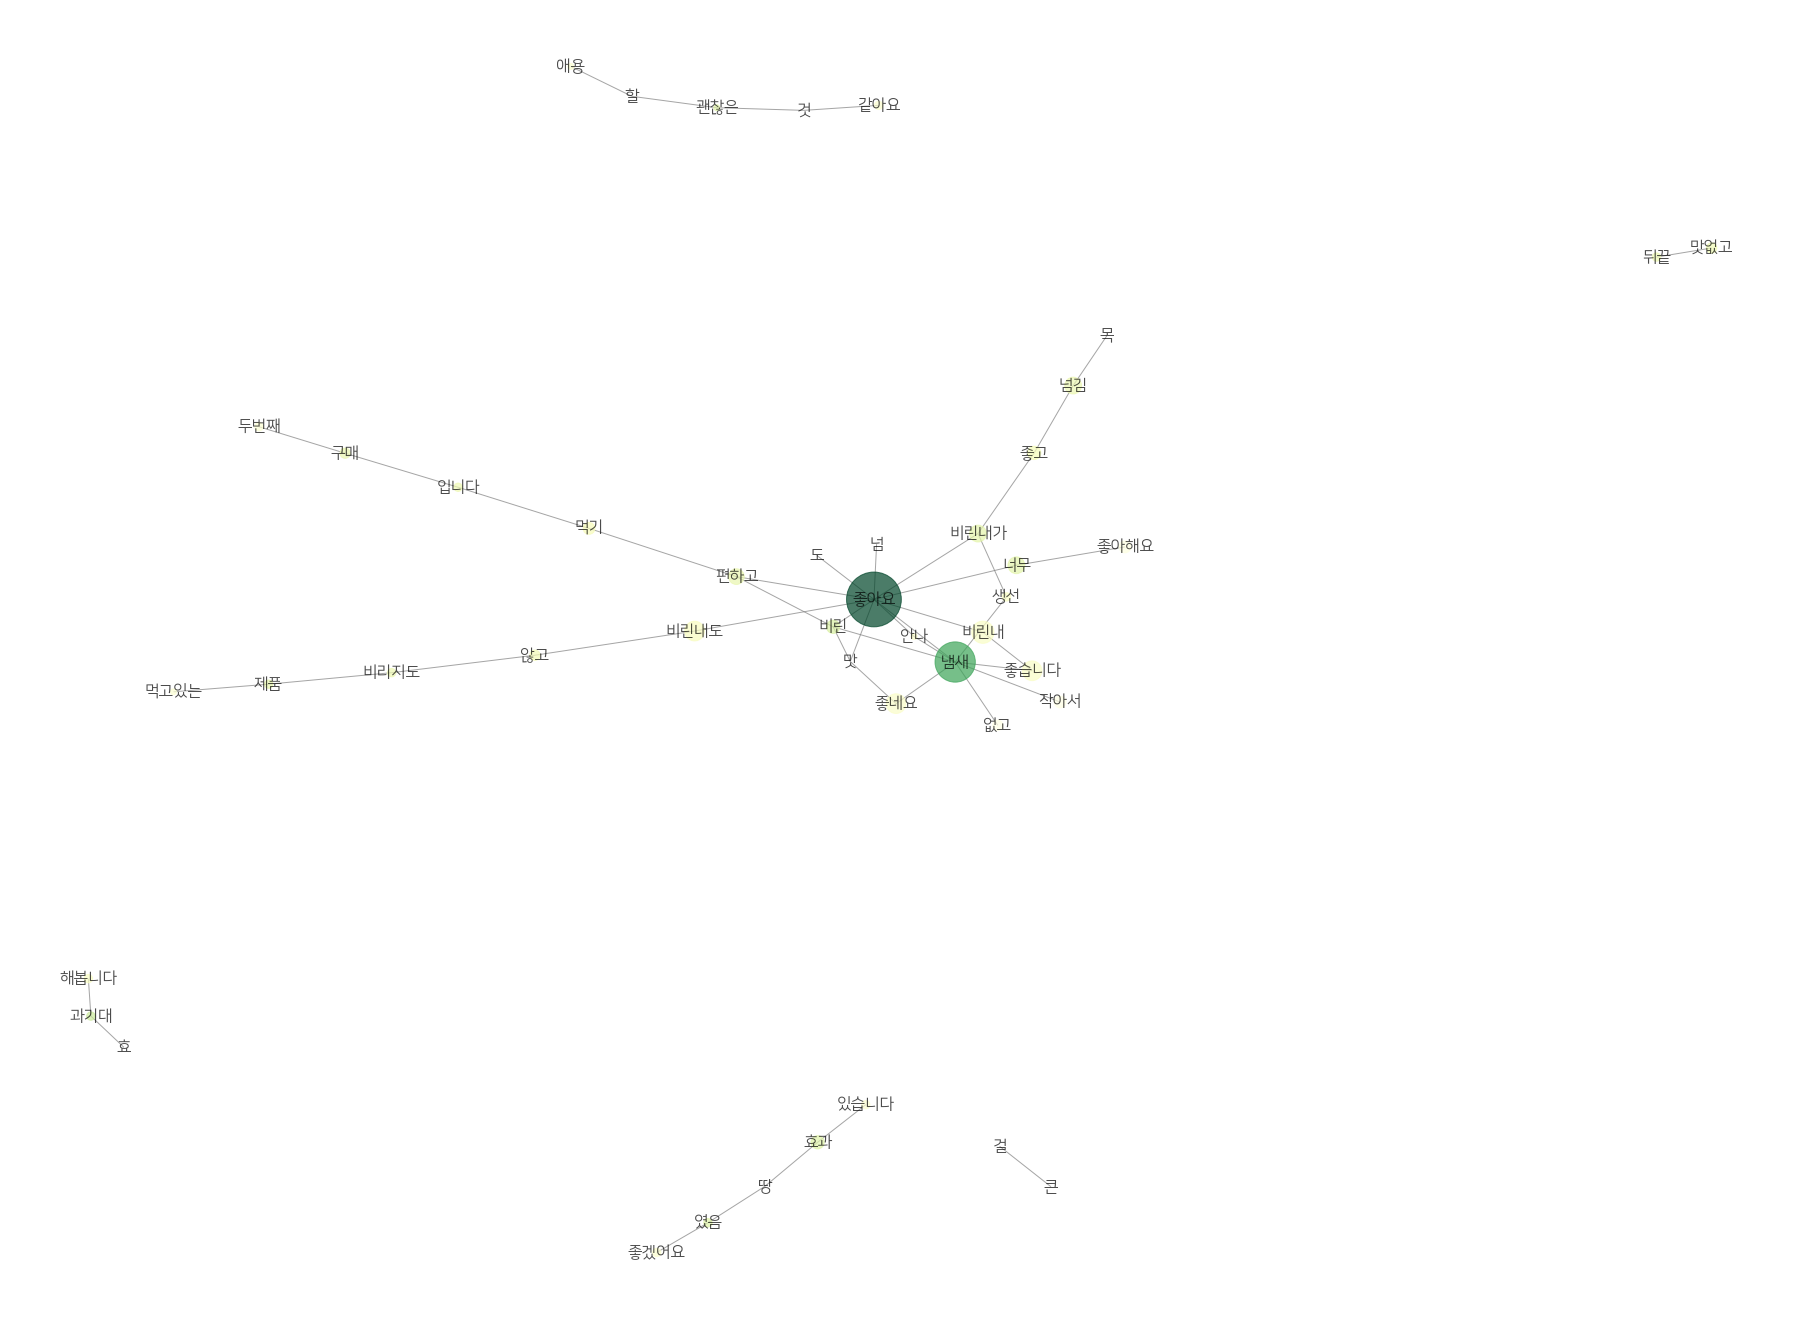

In [299]:
import networkx as nx 
G = nx.Graph()
G.add_edges_from(data['pair'])

pr = nx.pagerank(G)
# ncolor = np.array(list(pr.values()))
ncolor = np.array([count_dict[node] for node in list(G.nodes)])
nsize = 3000 * (ncolor - min(ncolor)) / (max(ncolor) - min(ncolor))
#pos = nx.kamada_kawai_layout(G, scale=5)


#pos = nx.draw(G)
#nx_agraph.pygraphviz_layout


plt.figure(figsize=(32, 24))
plt.axis('off')
nx.draw_networkx(G, font_family=fontprop.get_name(), font_size=16, pos=pos, node_color=list(pr.values()), node_size=nsize,
                 alpha=0.7, edge_color='.5', cmap=plt.cm.YlGn)